In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.ml import feature
from pyspark.ml import clustering, regression, evaluation
from pyspark.ml import clustering 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

import numpy as np

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import col, expr, when
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
#read in the netflow data
netflow = spark.read.csv('netflow.csv', header=True, inferSchema=True)

In [3]:
netflow.columns

['dest_ip',
 'dest_port',
 'src_ip',
 'src_port',
 'app',
 'bytes',
 'bytes_in',
 'bytes_out',
 'timestamp',
 'endtime',
 '_indextime',
 '_raw',
 '_sourcetype',
 '_subsecond',
 '_time']

In [5]:
#do not need the last 3 columns because it is Splunk add-ons
netflow_tcp = netflow.select(netflow.columns[0:10])

In [ ]:
#the number of distinct destination IP addresses in the dataset
netflow_tcp.select("dest_ip").distinct().count()

In [ ]:
#the number of distinct dest_ip dest_port combinations
netflow_tcp.select("dest_ip", "dest_port").distinct().count()

In [ ]:
#the number of distinct source IP addresses in the dataset
netflow_tcp.select("src_ip").distinct().count()

In [5]:
#the number of distinct src_ip src_port combinations
netflow_tcp.select("src_ip", "src_port").distinct().count()

220804

Lets identify how many IP Addresses are in the dest_ip range

In [ ]:
netflow_tcp.groupBy('dest_ip').count().show(200)

The return shows there is over 200.  Some appear often, othe appear only once.  Will break up by hour and then calculate by hour the distribution of connections. 

### Large Web Upload & Total Bytes z-score Distribution
#### Steps
- 1 develop a user defined function (udf)
- 2 calcualte mean and standard deviation
- 3 run the udf withColumn bytes calcualted
- 4 classify all rows where z-score is higher than 2.58 or less than -2.58
- 5 classify all rows where total bytes is larger than 35MB.

In [6]:
from pyspark.sql.functions import mean, stddev, col
#mean total bytes
mean = netflow_tcp.select(mean(col("bytes"))).alias("mean").collect()[0]
#standard deviation
stdev = netflow_tcp.select(stddev("bytes")).alias("sdev").collect()[0]

In [7]:
from pyspark.sql.functions import udf
#compute the z-score for each total bytes
def z_score(col):
    #average = mean(col)
    #standard_dev = stddev(col)
    #score = np.absolute((col - mean[0]) / stdev[0])
    return (col - mean[0]) / stdev[0]
z_udf = udf(z_score)

netflow_z = netflow_tcp.withColumn("z_score", z_udf("bytes"))
#netflow_z = netflow_z.select


In [8]:
#classify z-score higher than 2.58 as 1 else 0 => 2.58 is z_score between 3 and 3 standard deviations.  
netflow_z = netflow_z.select(col("*"), fn.expr("case when z_score > 2.58 OR z_score < -2.58 then 1 else 0 end").alias("z_score_class"))

In [13]:
#check to see which dest_port and src_ip combinations have a z_score_class of 1
netflow_z.select("dest_ip", "dest_port", "src_ip", "src_port", "app", "z_score_class").where("z_score_class == 1").show()

+--------------+---------+------------+--------+-----------+-------------+
|       dest_ip|dest_port|      src_ip|src_port|        app|z_score_class|
+--------------+---------+------------+--------+-----------+-------------+
| 52.42.208.228|     3306|172.31.10.10|   42328|        ssl|            1|
|  172.31.4.249|     3306|52.40.10.231|   41479|      mysql|            1|
| 52.42.208.228|     3306|172.31.10.10|   41479|      mysql|            1|
| 52.42.208.228|     3306|172.31.10.10|   37954|        ssl|            1|
|199.117.103.25|       80|  10.0.2.101|   56914|        cnn|            1|
|199.117.103.33|       80|  10.0.2.101|   56753|        cnn|            1|
|173.222.45.139|      443|  10.0.2.101|   56522|     sizmek|            1|
|173.194.54.218|       80|  10.0.2.101|   56041|google_play|            1|
| 52.42.208.228|     3306|172.31.10.10|   42328|        ssl|            1|
| 52.42.208.228|     3306|172.31.10.10|   41479|      mysql|            1|
| 52.42.208.228|     3306

The above returns 5198 values where the z_score is greater than 2.58... or 99% confidence interval or greater. Additionally, looking at the traffic above, the IP address 52.42.208.228 is the **destination** and is using port 3306, which is standard for MYSQL with SSL or other encryption  

App sizmek is an amazon company which is used for advertising. 

Need to understand the ports and IP addresses with z_score_class of 1

In [ ]:
netflow_z.select("dest_ip", "dest_port", "src_ip", "src_port", "app", "z_score_class").where("z_score_class == 1").groupBy("dest_ip","dest_port").count().show()

The port grouping shows IP address 172.31.10.10 connecting on 10001 and 443.  Port 10001 is used by protocol SCP and used for online gaming, trojans, backdoors, and Network Attached Storage (NAS).  The IP Address is in the private range and not routeable. 

In [ ]:
netflow_z.select("dest_ip", "dest_port", "src_ip", "src_port", "app", "z_score_class").where("z_score_class == 1").groupBy("dest_ip").count().show()

The above shows the distribution of IP addresses that have anomolous bytes size based on z_score > 2.58 OR < -2.58

### Large Web Upload

In [ ]:
# get the number of records where the value is greater than 35MB
netflow_z.where('bytes > 35000000').count().show() # returns 78 counts

In [11]:
#label all the traffic with large web upload.
netflow_z_up = netflow_z.select("*", when(col("bytes") > 35000000, 1).otherwise(0).alias("large_upload"))

# Label TOR traffic
#### Steps
Tor typically uses TCP ports 9001, 9030, 9150
- 1 find all dest and src ports where ports match with TOR traffic
- 2 label the rows

In [ ]:
#sms_spam2_df = sms_spam_df.select('text', when(col("type") == 'spam', 1.0).otherwise(0).alias('type'))
netflow_z.where('dest_port == 9001 OR dest_port == 9030 OR dest_port == 9150 OR dest_port == 31337').count() #returns 28 counts

In [ ]:
netflow_z.where('src_port == 9001 OR src_port == 9030 OR src_port == 9150 OR src_port == 31337').count() #returns 8 counts

In [13]:
#create a new column for all flows that meet the case of meeting one or more of the tor port conditions... where if yes then 1, otherwise 0.

netflow_z_up = netflow_z_up.select(col("*"), fn.expr("case when dest_port == 9001 OR dest_port == 9030 OR dest_port == 9150 OR dest_port == 31337 OR src_port == 9001 OR src_port == 9030 OR src_port == 9150 OR src_port == 31337 then 1 else 0 end").alias("tor_class"))


# Time Difference error Distribution
#### Steps
- 1 create a new column with the diff of timestamp and endtime
- 2 get the mean and standard deviation of the time
- 3 calculate the z-score for the time
- 4 label all times that are outliers (+- 2.58)

In [2]:
import datetime
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second, mean, unix_timestamp, substring, abs
from pyspark.sql.window import Window
from pyspark.sql import functions as func
from scipy import stats
from datetime import timedelta
#newDF = df.orderBy(unix_timestamp(df("stringCol"), pattern).cast("timestamp"))

In [16]:
#order the dataframe by 'timestamp'
netflow_z = netflow_z_up.orderBy(unix_timestamp(netflow_z["timestamp"]))

In [17]:
netflow_z.dtypes[8:]

[('timestamp', 'timestamp'),
 ('endtime', 'timestamp'),
 ('z_score', 'string'),
 ('z_score_class', 'int'),
 ('large_upload', 'int'),
 ('tor_class', 'int')]

In [22]:
# Time Diff
timeFmt = "yyyy-MM-dd' 'HH:mm:ss.SSS"
#netflow_time_diff = netflow_z_up\
netflow_time_diff = netflow_z\
    .withColumn('start_msec', unix_timestamp('timestamp', format=timeFmt) + substring('timestamp', -3, 3).cast('float')/1000)\
    .withColumn('end_msec', unix_timestamp('endtime', format=timeFmt) + substring('endtime', -3, 3).cast('float')/1000)\
    .withColumn('diff_msec', (abs(col('start_msec') - col('end_msec')).cast('double')))

In [25]:
from pyspark.sql.functions import mean, stddev, col

#get the mean of diff time
#mean total bytes
mean_msec = netflow_time_diff.select(mean(col("diff_msec"))).alias("mean_msec").collect()[0]
#get the standard deviation of diff time
#standard deviation
stdev_msec = netflow_time_diff.select(stddev("diff_msec")).alias("stdev_msec").collect()[0]


In [16]:
print("mean:", mean_msec[0], "standard dev:", stdev_msec[0])

mean: 299.23850464502044 standard dev: 613.9616176450414


In [28]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

#create a user defined function for the diff time
def z_score_time(col):
    return (col - mean_msec[0]) / stdev_msec[0]
z_udf = udf(lambda z: z_score_time(z), DoubleType())

netflow_time = netflow_time_diff.select('*', z_udf("diff_msec").alias('z_score_time'))

In [29]:
netflow_time.select("z_score_time").show(10, False)

+--------------------+
|z_score_time        |
+--------------------+
|60.36249951593672   |
|60.36249951593672   |
|60.36249951593672   |
|60.36249951593672   |
|-0.21945590481709806|
|0.31720629813789736 |
|-0.2111035916665231 |
|-0.38229995792985855|
|-0.47661529859911056|
|-0.09770236778612007|
+--------------------+
only showing top 10 rows



In [32]:
#####ERRRRROOOORRRRR ######
#this does not work because ... well... I just cannot figure out why it does not work. Something to do with unsupported type
#TypeError: unsupported operand type(s) for -: 'NoneType' and 'float' -> referencing z_score_time

netflow_time.select('z_score_time').where("z_score_time > 2.58").show()

Py4JJavaError: An error occurred while calling o360.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 21.0 failed 1 times, most recent failure: Lost task 1.0 in stage 21.0 (TID 816, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-28-580685a6bf38>", line 10, in <lambda>
  File "<ipython-input-28-580685a6bf38>", line 9, in z_score_time
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.random.SamplingUtils$.reservoirSampleAndCount(SamplingUtils.scala:41)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:306)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:304)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$25.apply(RDD.scala:853)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$25.apply(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:224)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:91)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:374)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec.doExecute(EvalPythonExec.scala:87)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:374)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:339)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2759)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:255)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:292)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-28-580685a6bf38>", line 10, in <lambda>
  File "<ipython-input-28-580685a6bf38>", line 9, in z_score_time
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.random.SamplingUtils$.reservoirSampleAndCount(SamplingUtils.scala:41)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:306)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:304)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$25.apply(RDD.scala:853)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$25.apply(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [47]:
from pyspark.sql.functions import isnull
#df.where(df.a.isNull()).count()
netflow_time_diff.select(isnull('time_z_score')).count()


#.where(netflow_time_diff.z_score_time.isNull()).count()

2036985

In [46]:
#another techinque to cast the time as a Double type
from pyspark.sql.types import DoubleType
netflow_time_diff = netflow_time_diff.withColumn("time_z_score", netflow_time_diff["z_score_time"].cast(DoubleType()))

In [49]:
netflow_time_diff.select("time_z_score").show(10)

+--------------------+
|        time_z_score|
+--------------------+
|   60.36249909441595|
|   60.36249909441595|
|   60.36249909441595|
|   60.36249909441595|
|-0.21945589706690755|
|  0.3172062993391025|
| -0.2111035985269344|
| -0.3822999584602314|
| -0.4766153069898921|
|  -0.097702359462893|
+--------------------+
only showing top 10 rows



In [ ]:
#classify z-score higher than 2.58 as 1 else 0 => 2.58 is z_score between 3 and 3 standard deviations.  
netflow_df = netflow_time_diff.select(col("*"), fn.expr("case when z_score_time > 2 OR z_score_time < -2 then 1 else 0 end").alias("z_score_time_class"))

# New IP Address connection from private subnet
#### Steps
- 1 Identify Private IP addresses
- 2 Calculate IP addresses per hour
- 3 If IP address per hour is new, label it anomolous


In [34]:
#order the dataframe by 'timestamp'
netflow_z = netflow_time_diff.orderBy(unix_timestamp(netflow_z["timestamp"]))

In [35]:
netflow_pd = netflow_z.toPandas()

In [183]:
netflow_pd.head(2)

,dest_ip,dest_port,src_ip,src_port,app,bytes,bytes_in,bytes_out,timestamp,endtime,z_score,diff_time_ms,private
0,10.0.1.100,135,10.0.1.1,39814,msrpc,1470,838,632,2017-08-01 18:29:25.404,2017-08-01 18:29:35.335,-0.024271898960842864,00:00:09.931000,0
1,172.31.10.10,443,52.34.175.192,60761,ssl,5045,1926,3119,2017-08-01 18:31:09.521,2017-08-01 18:22:16.052,-0.023062881596103615,00:08:53.469000,NaN


In [36]:
#iterate through dataframe... if private to private match, the return 0, else will return NaN 
netflow_pd.loc[(netflow_pd.dest_ip.str.contains('10.0|172.31|192.168')) & (netflow_pd.src_ip.str.contains('10.0|172.31|192.168')), 'private'] = 0

In [37]:
#fill all values of NaN with 1 meaning 1 is not a private to private mapping
netflow_pd['private'] = netflow_pd.private.fillna(1)

In [38]:
#check if the non_private 
netflow_pd.head(1)

,dest_ip,dest_port,src_ip,src_port,app,bytes,bytes_in,bytes_out,timestamp,endtime,z_score,z_score_class,large_upload,tor_class,private
0,40.97.128.34,443,10.0.2.109,58107,office365,1441608,167497,1274111,2017-07-31 14:46:43.264,2017-08-01 01:09:22.761,0.46276358345058344,0,0,0,1.0


In [39]:
#save pandas dataframe locally
netflow_pd.to_csv('netflow_data.csv', sep=',', encoding='utf-8')

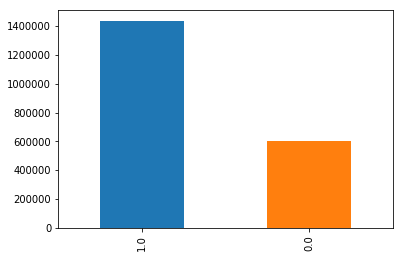

In [24]:
#create historgram showing count of private to private and not
netflow_pd['private'].value_counts().plot(kind='bar')
#we can see there is a significant amount of non private to private communication

In [40]:
#convert the dataframe back to a spark, this will contain a new data_frame that has a private column 
netflow_data = spark.createDataFrame(netflow_pd)

In [30]:
#evaluate the counts 
aggs_dest_test = netflow_data.groupBy("dest_ip", "dest_port", "date", "hour", "private").count()

In [ ]:
aggs_dest_test.show()

##### This part is for sliding window... did not get to compute it yet

In [6]:
#need to set up a sliding window for time bucketed by hour
#step 1... sort the dataframe from timestamp by order
#step 1b... convert timestamp to unix_timestamp
## this was already done above before with netflow_data
netflow_data = netflow_data.orderBy(unix_timestamp(netflow_data["timestamp"]))


In [ ]:
#step 2... set up a window of time
#get the number of seconds in a day
#function to calculate number of seconds from number of days: thanks Bob Swain
days = lambda i: i * 86400

#need timestamp as seconds for our Window time frame
#DO NOT NEED THE BELOW CODE LINE... 'timestamp' IS ALREADY A TIMESTAMP
test_df = netflow_df.withColumn('timestamp_sec', netflow_df.timestamp.cast('timestamp'))
#df.orderBy(org.apache.spark.sql.functions.col("columnname").desc)

##### *XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [8]:
# Create a NEW COLUMNS for the date, hour, and second for calculations
netflow_data = (netflow_data
  .withColumn("date", col("timestamp").cast("date"))
  .withColumn("hour", hour(col("timestamp")))
  .withColumn("second", second(col('timestamp'))))

In [9]:
aggs_dest_day = netflow_data.groupBy("dest_ip", "dest_port", "date").count()

In [11]:
aggs_dest_day.where('count > 5000').show()

+------------+---------+----------+-----+
|     dest_ip|dest_port|      date|count|
+------------+---------+----------+-----+
|  10.0.1.100|      135|2017-08-23| 8865|
|  10.0.1.100|      135|2017-08-05| 9390|
|172.31.4.249|       80|2017-08-18|10424|
|172.31.10.10|      443|2017-08-08|15709|
|172.31.10.10|      443|2017-08-27|13295|
|  10.0.1.100|      135|2017-08-30| 8865|
|  10.0.1.100|      135|2017-08-16| 9801|
|  10.0.1.100|    49155|2017-08-03| 5027|
|  10.0.1.100|    49155|2017-08-08| 5253|
|  10.0.1.100|      135|2017-08-10| 9552|
|172.31.10.10|      443|2017-08-21|13295|
|  10.0.1.100|    49155|2017-08-26| 8504|
|172.31.10.10|      443|2017-08-30|13295|
|172.31.6.251|       22|2017-08-19| 7580|
|172.31.4.249|       80|2017-08-19|10599|
|  10.0.1.100|      135|2017-08-25|11112|
|172.31.4.249|       80|2017-08-06|10384|
|172.31.10.10|      443|2017-08-03|15331|
|  10.0.1.100|    49155|2017-08-11| 5152|
|  10.0.1.100|      135|2017-08-26|16770|
+------------+---------+----------

In [24]:
#compute the aggregates
aggs_dest_port =netflow_data.groupBy("dest_ip", "dest_port", "date", "hour").count()

In [38]:
#identify if any of the port counts by date -> hour is greater than 1000
aggs_dest_port.where("count > 1000").show()

+------------+---------+----------+----+-----+
|     dest_ip|dest_port|      date|hour|count|
+------------+---------+----------+----+-----+
|172.31.10.10|      443|2017-08-18|  23| 3891|
|  10.0.1.100|      135|2017-08-18|  23| 2623|
|172.31.10.10|      443|2017-08-19|   6| 4179|
|172.31.10.10|      443|2017-08-26|   8| 3021|
|  10.0.1.100|    49155|2017-08-29|  10| 1233|
|45.77.65.211|      443|2017-08-25|   4| 2038|
|  10.0.1.100|      135|2017-08-19|   7| 2943|
|  10.0.1.100|      135|2017-08-24|   3| 2283|
|172.31.4.249|       80|2017-08-11|  15| 1003|
|172.31.10.10|      443|2017-08-25|   5| 2511|
|  10.0.1.100|    49155|2017-08-19|  12| 1579|
|172.31.10.10|      443|2017-08-19|  12| 4589|
|  10.0.1.100|    49155|2017-08-19|   9| 1642|
|  10.0.1.100|      135|2017-08-29|  10| 2477|
|  10.0.1.100|      135|2017-08-25|   5| 1484|
|  10.0.1.100|    49155|2017-08-26|   7| 1459|
|172.31.10.10|      443|2017-08-08|  13| 1306|
|  10.0.1.100|    49155|2017-08-19|   4| 1388|
|45.77.65.211

In [ ]:
#compute the aggregates
aggs_dest_ip = netflow_data.groupBy("dest_ip", "date", "hour").count()

In [ ]:
aggs_dest_ip.where("date == '2017-08-19' AND hour == 3").show()

In [13]:
aggs_dest_ip.where("date == '2017-08-19' AND hour == 3 AND dest_port == 22").show()

+-------------+---------+----------+----+-----+
|      dest_ip|dest_port|      date|hour|count|
+-------------+---------+----------+----+-----+
| 172.31.6.251|       22|2017-08-19|   3|  725|
|52.42.208.228|       22|2017-08-19|   3|    1|
| 172.31.4.249|       22|2017-08-19|   3|  215|
| 172.31.10.10|       22|2017-08-19|   3|   20|
|172.31.38.181|       22|2017-08-19|   3|   15|
| 172.31.13.46|       22|2017-08-19|   3|   11|
| 172.31.7.219|       22|2017-08-19|   3|   13|
+-------------+---------+----------+----+-----+



In [13]:
#label ssh traffic with the given date, hour, and dest_port  
netflow_data = netflow_data.select(col("*"), fn.expr("case when date == '2017-08-19' AND hour == 3 AND dest_port == 22 then 1 else 0 end").alias("bad_traffic"))

In [14]:
#label suspicious traffic with the given date, hour, and dest_port  
netflow_data = netflow_data.select(col("*"), fn.expr("case when date == '2017-08-11' AND hour == 14 AND dest_port == 80 OR date == '2017-08-18' AND hour == 22 AND dest_port == 443 OR date == '2017-08-26' AND hour == 6 AND dest_port == 443 OR date == '2017-08-26' AND hour == 7 AND dest_port == 443 then 1 else 0 end").alias("suspicious_traffic"))

# Save the dataframe

In [ ]:
netflow_pd = netflow_data.toPandas()

In [ ]:
#save pandas dataframe locally
netflow_pd.to_csv('netflow_data.csv', sep=',', encoding='utf-8')